In [77]:
!pip install tensorflow-gpu==2.0.0
import tensorflow as tf

import numpy as np
import os
import time

In [0]:
# 학습시킬 데이터(셰익스피어) 다운로드
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [79]:
raw_data = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print ('raw data length: {}'.format(len(raw_data)))

raw data length: 1115394


In [0]:
raw_data = raw_data[:200000]

In [81]:
unique_chars = sorted(set(raw_data))
print('unique word : {}'.format(unique_chars))
print('unique word num : {}'.format(len(unique_chars)))

unique word : ['\n', ' ', '!', '&', "'", ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
unique word num : 62


In [0]:
char_to_int = {u:i for i,u in enumerate(unique_chars)}
int_to_char = np.array(unique_chars)

text_as_int = np.array([char_to_int[c] for c in raw_data])

In [83]:
print ('{} ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > {}'.format(repr(raw_data[:13]), text_as_int[:13]))

'First Citizen' ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > [16 44 53 54 55  1 13 44 55 44 61 40 49]


In [84]:
# 한번에 입력에 대해 원하는 문장의 최대 길이
seq_length = 50
examples_per_epoch = len(raw_data)//seq_length

# 훈련 샘플/타깃 만들기
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(int_to_char[i.numpy()])

F
i
r
s
t


In [85]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(int_to_char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear '
'me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou a'
're all resolved rather to die than to famish?\n\nAll:'
'\nResolved. resolved.\n\nFirst Citizen:\nFirst, you kno'
'w Caius Marcius is chief enemy to the people.\n\nAll:'


In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1] # input데이터는 마지막 데이터전까지
    target_text = chunk[1:] # target데이터는 인풋처음 다음 문자부터
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [87]:
for input_example, target_example in  dataset.take(1):
  print ('입력 데이터: ', repr(''.join(int_to_char[input_example.numpy()])))
  print ('타깃 데이터: ', repr(''.join(int_to_char[target_example.numpy()])))

입력 데이터:  'First Citizen:\nBefore we proceed any further, hear'
타깃 데이터:  'irst Citizen:\nBefore we proceed any further, hear '


In [88]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("{:4d}단계".format(i))
    print("  입력: {} ({:s})".format(input_idx, repr(int_to_char[input_idx])))
    print("  예상 출력: {} ({:s})".format(target_idx, repr(int_to_char[target_idx])))

   0단계
  입력: 16 ('F')
  예상 출력: 44 ('i')
   1단계
  입력: 44 ('i')
  예상 출력: 53 ('r')
   2단계
  입력: 53 ('r')
  예상 출력: 54 ('s')
   3단계
  입력: 54 ('s')
  예상 출력: 55 ('t')
   4단계
  입력: 55 ('t')
  예상 출력: 1 (' ')


In [89]:
# 배치 크기
BATCH_SIZE = 100

# 데이터셋을 섞을 버퍼 크기
# (TF 데이터는 무한한 시퀀스와 함께 작동이 가능하도록 설계되었으며,
# 따라서 전체 시퀀스를 메모리에 섞지 않습니다. 대신에,
# 요소를 섞는 버퍼를 유지합니다).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((100, 50), (100, 50)), types: (tf.int64, tf.int64)>

In [0]:
# 문자로 된 어휘 사전의 크기
unique_size = len(unique_chars)

# 임베딩 차원
embedding_dim = 256

# RNN 유닛(unit) 개수
rnn_units = 32

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(unique_size, embedding_dim,
                            batch_input_shape=[BATCH_SIZE, None]),
  tf.keras.layers.LSTM(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.LSTM(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.LSTM(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.Dense(unique_size)
])

In [92]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (배치 크기, 시퀀스 길이, 어휘 사전 크기)")

(100, 50, 62) # (배치 크기, 시퀀스 길이, 어휘 사전 크기)


In [93]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (100, None, 256)          15872     
_________________________________________________________________
lstm_12 (LSTM)               (100, None, 32)           36992     
_________________________________________________________________
lstm_13 (LSTM)               (100, None, 32)           8320      
_________________________________________________________________
lstm_14 (LSTM)               (100, None, 32)           8320      
_________________________________________________________________
dense_4 (Dense)              (100, None, 62)           2046      
Total params: 71,550
Trainable params: 71,550
Non-trainable params: 0
_________________________________________________________________


In [0]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [95]:
sampled_indices

array([34, 58, 12, 34, 23, 24,  3, 45,  9, 42, 19, 61, 52, 21, 57, 33, 27,
       34, 46, 42, 22, 11, 60, 19, 26, 38,  7,  0, 33, 34, 26, 55, 21,  3,
       58, 45, 19, 49, 32, 20, 60, 26, 58, 37, 17,  9, 23, 57, 26,  9])

In [96]:
print("입력: \n", repr("".join(int_to_char[input_example_batch[0]])))
print()
print("예측된 다음 문자: \n", repr("".join(int_to_char[sampled_indices])))

입력: 
 "flattered the people, who ne'er loved them; and th"

예측된 다음 문자: 
 'YwBYMN&j;gIzqKvWQYkgLAyIPc.\nWYPtK&wjInVJyPwbG;MvP;'


In [97]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("예측 배열 크기(shape): ", example_batch_predictions.shape, " # (배치 크기, 시퀀스 길이, 어휘 사전 크기")
print("스칼라 손실:          ", example_batch_loss.numpy().mean())

예측 배열 크기(shape):  (100, 50, 62)  # (배치 크기, 시퀀스 길이, 어휘 사전 크기
스칼라 손실:           4.127204


In [0]:
model.compile(optimizer='adam', loss=loss)

In [0]:
# 체크포인트가 저장될 디렉토리
checkpoint_dir = './training_checkpoints'
# 체크포인트 파일 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [0]:
EPOCHS=100

In [51]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/100
39/39 [==============================] - 7s 186ms/step - loss: 3.7715
Epoch 2/100
39/39 [==============================] - 2s 54ms/step - loss: 3.3443
Epoch 3/100
39/39 [==============================] - 2s 55ms/step - loss: 3.3072
Epoch 4/100
39/39 [==============================] - 2s 55ms/step - loss: 3.3036
Epoch 5/100
39/39 [==============================] - 2s 54ms/step - loss: 3.2981
Epoch 6/100
39/39 [==============================] - 2s 55ms/step - loss: 3.2797
Epoch 7/100
39/39 [==============================] - 2s 56ms/step - loss: 3.2059
Epoch 8/100
39/39 [==============================] - 2s 56ms/step - loss: 3.0859
Epoch 9/100
39/39 [==============================] - 2s 55ms/step - loss: 2.9769
Epoch 10/100
39/39 [==============================] - 2s 54ms/step - loss: 2.8996
Epoch 11/100
39/39 [==============================] - 2s 55ms/step - loss: 2.8339
Epoch 12/100
39/39 [==============================] - 2s 55ms/step - loss: 2.7673
Epoch 13/100
39/39 [====

In [101]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_100'

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(unique_size, embedding_dim,
                            batch_input_shape=[1, None]),
  tf.keras.layers.LSTM(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.LSTM(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.LSTM(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.Dense(unique_size)
])

In [0]:
#학습한 weights checkpoint를 통하여 설정
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [108]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (1, None, 256)            15872     
_________________________________________________________________
lstm_15 (LSTM)               (1, None, 32)             36992     
_________________________________________________________________
lstm_16 (LSTM)               (1, None, 32)             8320      
_________________________________________________________________
lstm_17 (LSTM)               (1, None, 32)             8320      
_________________________________________________________________
dense_5 (Dense)              (1, None, 62)             2046      
Total params: 71,550
Trainable params: 71,550
Non-trainable params: 0
_________________________________________________________________


In [0]:
def generate_text(model, start_string):
  # 평가 단계 (학습된 모델을 사용하여 텍스트 생성)

  # 생성할 문자의 수
  num_generate = 1000

  # 시작 문자열을 숫자로 변환(벡터화)
  input_eval = [char_to_int[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # 결과를 저장할 빈 문자열
  text_generated = []

  # 온도가 낮으면 더 예측 가능한 텍스트가 됩니다.
  # 온도가 높으면 더 의외의 텍스트가 됩니다.
  # 최적의 세팅을 찾기 위한 실험
  temperature = 1.0

  # 여기에서 배치 크기 == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # 배치 차원 제거
      predictions = tf.squeeze(predictions, 0)

      # 범주형 분포를 사용하여 모델에서 리턴한 단어 예측
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # 예측된 단어를 다음 입력으로 모델에 전달
      # 이전 은닉 상태와 함께
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(int_to_char[predicted_id])

  return (start_string + ''.join(text_generated))

In [110]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: eyll thy in sivence, astancere
Is deanglising ucance.

Fe
A:
Why you lame.

QUEENRY:
God if wroulnter
The mible diont;
And brith.

SICINIUS:
Apcom sigh if nos befe'd sont; on deapes to laid wither your thy dae ye poRHENR:
Thul. What your estey, brant.

S'd under!
Theine the gorse-have of stersed cor ren wron.

Fir.

CORIOLNNIUS:
Rithist thinsi the med. Where, shat, Gady, ham he is roash
And cour actitous goattitire I hep the a cat of. Sey gmine the hid with -Ou
If have spever evem my.

BRUS:
Onct, if, itter gord,
Iud nowewes hagtirens.

Firsiey his he rash of son Rome belindters, in reath but sweir.

QUEEND Inlak seroth thele hay it rakise worplinciomerons with
Tham Marcond.

SICINIUS:
Thougene!

Fy buhousteroun that many.


VOLUERIORSS:
To perven my of thee. Yer you wrace he have ofpelne
Thou the ans's hoou, know stun his mone tere; me is and hill abcewes acall it water ingous, fel stercgerang freer in forsort, are your tomes and ilhits, with Seed you; here cond his geckster an

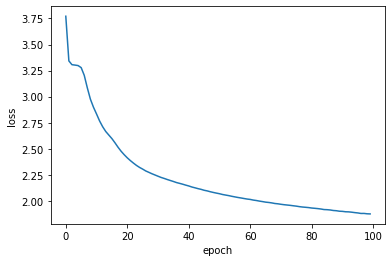

In [111]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
